In [14]:
%matplotlib inline
from matplotlib import pyplot as plt
from matminer.featurizers.base import MultipleFeaturizer, StackedFeaturizer
from matminer.featurizers import composition as cf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, ShuffleSplit, LeaveOneGroupOut, cross_val_score, learning_curve, KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, LabelEncoder
from sklearn.metrics import roc_curve, auc, r2_score, make_scorer, mean_absolute_error
from sklearn.feature_selection import RFECV
from sklearn import metrics
from pymatgen import Composition
import pickle as pkl
import pandas as pd
import numpy as np
import gzip
import os
import re

In [15]:
saveFigures=False

In [16]:
def featCleanImpute(Y):
    ''' Convert inf to NaN in feature array, in place
    
    Args: 
        Y, feature array, list of ndarray (#samples x #features)
    Returns:
        None
    '''
    # Clean inf values
    for i in range(len(Y)):
        for j in range(len(Y[i])):
            if Y[i][j] == np.inf:
                Y[i][j] = np.nan
            else:
                Y[i][j] = Y[i][j]
                
    # Impute nan values
    imp = Imputer(missing_values='NaN', axis=0, strategy='mean', copy=False)
    imp2 = Imputer(missing_values='NaN', axis=1, strategy='mean', copy=False)

    imp.fit(Y)
    imp.transform(Y)
    imp2.fit(Y)
    imp.transform(Y)
    

# Build Model: Density

Import feature set, import data

In [17]:
with gzip.open('./datasets/density_features.pkl.gz', 'rb') as fp:
    X_dens = pkl.load(fp)
with gzip.open('./datasets/density_data.pkl.gz', 'rb') as fd:
    densityData = pkl.load(fd)

In [18]:
density_model = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [19]:
%%time
density_model.fit(X_dens, y=densityData['density'])

Wall time: 359 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [20]:
# make scorer for r2 metric
r2_scorer = make_scorer(r2_score)

In [21]:
np.shape(X_dens)

(701, 152)

# Assess quality of model, identify outliers, refine model

Compare to Vegard's law, rule of mixtures

In [22]:
elemProp = pd.read_excel('datasets/ElementalDensityIonizationTable.xlsx')
elemDensity = elemProp[['symbol', 'density [g/cm3]']]

def vegardsDensity(comp):
    '''
    input: Composition object
    '''
        
    density=0
    elemSet = set(comp.elements)
    subscriptCnt = 0
    
    for elem in elemSet:
        subscriptCnt += comp[elem]
        try: 
            densityPart = comp[elem]*elemDensity[ elemDensity['symbol'] == str(elem)]['density [g/cm3]'].item()
        except:
            print('element {} not found?'.format(elem))
            return 'error'
            
        density += densityPart
        # print('element {} added density of {}: {}'.format(elem, densityPart, density))
                
    # print(subscriptCnt)
    return density / subscriptCnt

In [23]:
densityData['density_vegards'] = np.nan
densityData['density_vegards'] = [vegardsDensity(c) for c in densityData['comp']]

In [25]:
densDiffModel = Pipeline([('impute',Imputer()), 
                          ('model', RandomForestRegressor(n_estimators=100, n_jobs=1, max_features=12))])

Remove the compositions with issues

In [29]:
#  Examine performance without outliers (trouble compositions)
compTrouble = Composition('Zr57 Nb5 Al10 Cu15.4 Ni12.6')
notTroubleDF = densityData[ [not compTrouble.almost_equals(c) for c in densityData['comp']] ]
notTroubleDF.reset_index(inplace=True, drop=True)
#print('Deviation Prediction, r2 sans outliers: {}'.format(r2_score(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])))

Train Models on cleaned datasets

In [30]:
X_notTrouble = X_dens[ [not compTrouble.almost_equals(c) for c in densityData['comp']] ]

In [37]:
# how is learning in general without outliers?  Train on whole feature set
densFeatTop = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['density_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}'.format(rep))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['density'][train_index])
    
    y_densPredict = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['density_predict'][test_index] = y_densPredict
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    densFeatTop = densFeatTop.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0
Split #1
Split #2
Split #3
Split #4


In [32]:
densFeatTop['totalImp'] = densFeatTop.groupby(level=0)['importance'].transform('sum')
densFeatTop = densFeatTop.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
densFeatTop.head()

#densFeatTop.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityNoOutliers.csv'))

top features over 5 training splits


,importance,totalImp
mode Number,0.047318,0.361291
mode AtomicWeight,0.039185,0.350855
mean NValence,0.069168,0.286100
mode NValence,0.051498,0.220318
mean AtomicWeight,0.014149,0.174919


In [36]:
# plot Comparison, report r2
r2noOut = r2_score(notTroubleDF['density'], notTroubleDF['density_predict'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_predict'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density without Outlier Comp')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2noOut))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('default model: density, drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_noOutliers_allFeats.png'))
    print('figure saved')

KeyError: 'density_predict'

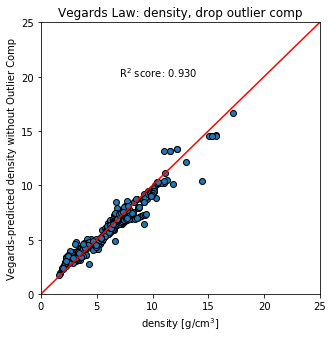

In [34]:
# plot Comparison, report r2
r2noOut = r2_score(notTroubleDF['density'], notTroubleDF['density_vegards'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['density'], notTroubleDF['density_vegards'], edgecolors='k')
plt.plot([0,30], [0,30], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('Vegards-predicted density without Outlier Comp')


plt.text(7,20, 'R$^2$ score: {:.3f}'.format(r2noOut))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Vegards Law: density, drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_noOutliers_vegards.png'))
    print('figure saved')

## Train on difference between density and vegards, see what features float up
Not including outliers

In [35]:
notTroubleDF.head()

,comp,density,density_vegards,density_predict_noOutlier
0,"(Ce, Al)",3.462,3.1070,4.003304
1,"(Al, Fe, B)",3.539,3.6620,5.370857
2,"(Zr, Al, Ni)",3.384,3.5105,4.077817
3,"(Zr, Al, Ni)",3.517,3.6965,4.147477
4,"(Hf, Al, Ni)",2.835,3.8505,5.392675


In [30]:
# Train on difference
diffFeatTop5 = pd.DataFrame()

# take predicted values from each cross validation set to ensure training not performed on own set.  Take 200 training samples
# Probably could have used cross_val_predict
kf = KFold(5)
rep=0
notTroubleDF['diff_predict'] = np.nan
for train_index, test_index in kf.split(notTroubleDF['comp']):
    print('Split #{}, training on {}'.format(rep, len(train_index)))
    density_model.fit(X_notTrouble[train_index,:], notTroubleDF['vegards_diff'][train_index])
    
    y_diffPredict = density_model.predict(X_notTrouble[test_index,:])
    notTroubleDF['diff_predict'][test_index] = y_diffPredict
    
    
    featureImp = pd.DataFrame(density_model.steps[1][1].feature_importances_,
                          index=dens_featurizer.feature_labels(),
                          columns=['importance']).sort_values('importance',ascending=False)
    #print(featureImp.head())
    
    diffFeatTop5 = diffFeatTop5.append(featureImp)

    
    #print(train_index, test_index)
    rep+=1
#y_densPredict = 

Split #0, training on 555
Split #1, training on 555
Split #2, training on 555
Split #3, training on 555
Split #4, training on 556


In [31]:
diffFeatTop5['totalImp'] = diffFeatTop5.groupby(level=0)['importance'].transform('sum')
diffFeatTop = diffFeatTop5.drop_duplicates(subset=['totalImp']).sort_values('totalImp',ascending=False)
print('top features over 5 training splits')
print(diffFeatTop.head())
#diffFeatTop.to_csv(os.path.join(os.getcwd(),'results','avgTopFeats_densityVegardsDiff.csv'))

top features over 5 training splits
                        importance  totalImp
minimum CovalentRadius    0.034623  0.172113
avg_dev Column            0.022170  0.151541
mean GSbandgap            0.022122  0.132762
avg_dev GSbandgap         0.021193  0.128066
mode MeltingT             0.012625  0.112080


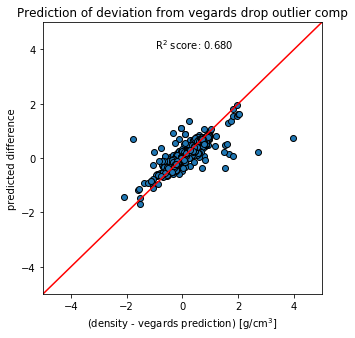

In [32]:
# plot Comparison, report r2
r2noOutDiff = r2_score(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'], edgecolors='k')
plt.plot([-5,5], [-5,5], 'r-')
plt.xlabel('(density - vegards prediction) [g/cm$^3$]')
plt.ylabel('predicted difference')


plt.text(-1,4, 'R$^2$ score: {:.3f}'.format(r2noOutDiff))
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.title('Prediction of deviation from vegards drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityDiffScatter_noOutliers.png'))
    print('figure saved')

In [33]:
# Look at mean absolute err with this new data set:

mae = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_predict_noOutlier'])
mae_vegards = mean_absolute_error(notTroubleDF['density'], notTroubleDF['density_vegards'])
print('MAE for random forest: {:.4f} vs vegards law {:.4f}'.format(mae, mae_vegards))
mae_diff = mean_absolute_error(notTroubleDF['vegards_diff'], notTroubleDF['diff_predict'])
print(mae_diff)

MAE for random forest: 0.2917 vs vegards law 0.4477
0.17670374179143386


# Assess performance of using difference predictions instead of full model 

0.9783041622145574


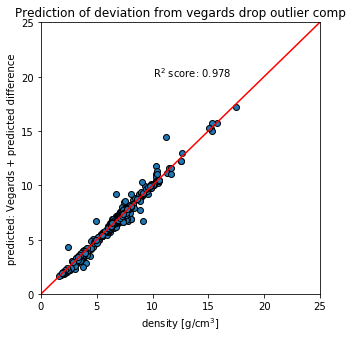

In [34]:
notTroubleDF['vPlusDiff'] = notTroubleDF['density_vegards'] + notTroubleDF['diff_predict']
r2Comp = r2_score(notTroubleDF['density'], notTroubleDF['vPlusDiff'])
print(r2Comp)

plt.figure(figsize=(5,5))
plt.scatter(notTroubleDF['vPlusDiff'], notTroubleDF['density'], edgecolors='k')
plt.plot([0,25], [0,25], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted: Vegards + predicted difference')


plt.text(10,20, 'R$^2$ score: {:.3f}'.format(r2Comp))
plt.xlim([0,25])
plt.ylim([0,25])
plt.title('Prediction of deviation from vegards drop outlier comp')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityDiffScatter_VegardsPlusDiff.png'))
    print('figure saved')

# Gather Materials Project data and try to predict compositions.

In [35]:
with gzip.open('./datasets/MAPI_density_data.pkl.gz', 'rb') as fd:
    MAPIdata = pkl.load(fd)

In [42]:
MAPIdata['density_vegards'] = [vegardsDensity(c) for c in MAPIdata['comp']]
MAPIdata['vegards_diff'] = MAPIdata['density'] - MAPIdata['density_vegards']

In [38]:
dens_featurizer = MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                                 cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True),
                                cf.YangSolidSolution(), cf.AtomicPackingEfficiency()])

In [40]:
%%time
subsetMAPI = MAPIdata.sample(n=701)

X_mapi = dens_featurizer.featurize_many(subsetMAPI['comp'], ignore_errors=True)
X_mapi = np.array(X_mapi)
X_mapi.astype(float)
print('Computed {} features'.format(X_mapi.shape[1]))


Computed 152 features
Wall time: 29min 39s


In [48]:
np.where(np.isnan(X_mapi))
featCleanImpute(X_mapi)
np.where(np.isnan(X_mapi))

(array([], dtype=int64), array([], dtype=int64))

In [54]:
subsetMAPI['density_vegards'] = [vegardsDensity(c) for c in MAPIdata['comp']]
subsetMAPI['vegards_diff'] = subsetMAPI['density'] - subsetMAPI['density_vegards']

ValueError: Length of values does not match length of index

In [43]:
MAPIdata.head()

,density,material_id,pretty_formula,comp,density_vegards,vegards_diff
0,5.752872,mp-20338,CeAl3Ni2,"(Ce, Al, Ni)",5.445000,0.307872
1,4.807903,mp-30750,CeAl4Ni,"(Ce, Al, Ni)",4.411667,0.396236
2,4.597243,mp-582245,Ce4Al23Ni6,"(Ce, Al, Ni)",4.320606,0.276637
3,6.768836,mp-11351,CeAlNi,"(Ce, Al, Ni)",6.123333,0.645503
4,4.901765,mp-4817,CeAl5Ni2,"(Ce, Al, Ni)",4.758750,0.143015


In [44]:
%%time 
# Train on all database info
density_model.fit(X_notTrouble, y=notTroubleDF['density'])

Wall time: 374 ms


Pipeline(memory=None,
     steps=[('impute', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('model', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=12, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False))])

In [49]:
%%time
# Predct MAPI data
yMAPI = density_model.predict(X_mapi)

Wall time: 15.6 ms


In [55]:
subsetMAPI['density_predict'] = yMAPI
r2_score(subsetMAPI['density'], subsetMAPI['density_predict'])

0.26645360070396906

0.26645360070396906


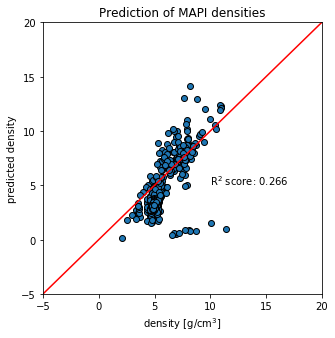

In [59]:
r2mapi = r2_score(subsetMAPI['density'], subsetMAPI['density_predict'])
print(r2mapi)

plt.figure(figsize=(5,5))
plt.scatter(subsetMAPI['density_predict'], subsetMAPI['density'], edgecolors='k')
plt.plot([-5,25], [-5,25], 'r-')
plt.xlabel('density [g/cm$^3$]')
plt.ylabel('predicted density')


plt.text(10,5, 'R$^2$ score: {:.3f}'.format(r2mapi))
plt.xlim([-5,20])
plt.ylim([-5,20])
plt.title('Prediction of MAPI densities')

if saveFigures:
    plt.savefig(os.path.join(os.getcwd(),'results','densityScatter_MAPI.png'))
    print('figure saved')